# UTK Faces: Gender Prediction based on latent representation

### Import Appropriate Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import cv2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA, IncrementalPCA


from sklearn.svm import SVC

### Complementary Functions

#### 1. **Sorting of files**

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

#### 2. Plot Image

In [3]:
def plt_face(x):
    h = 200
    w = 200
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])

#### 3. Plot Confusion Matrix

In [4]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "Performance:\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label\n')
        plt.xlabel('\nPredicted label\n\n\n\n' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

        
# From https://github.com/DTrimarchi10/confusion_matrix

### Load Data 

In [5]:
labels_path = "...\\labels.csv"
labels_full = pd.read_csv(labels_path, header = None)  
labels_full.columns = ['Age', 'Gender', 'Race']
print("Size of Dataset: ", labels_full.shape[0])

Size of Dataset:  23705


In [6]:
labels_full.head()

Age  Gender  Race
0  100       0     0
1  100       0     0
2  100       1     0
3  100       1     0
4  100       1     0

#### Load Images in Grayscale

First sort the images

In [7]:
filepath = "...\\Faces\\*.jpg"
filenames = [img for img in glob.glob(filepath)]
filenames.sort(key = natural_keys)
images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in filenames]

In [8]:
print('The dim of each image is :', images[1].shape)
print('The number of the images is :', len(images))

The dim of each image is : (200, 200)
The number of the images is : 23705


#### Plot Random Images

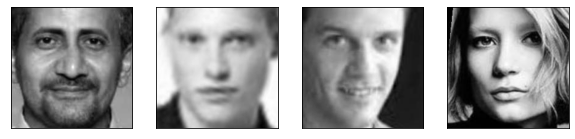

In [9]:
n_samples = len(images)
I = np.random.permutation(n_samples)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(images[ind])

#### Preprocessing of matrix X

Flatten each image and construct matrix X where each line represents an image and each column a specific pixel of the 200 $\times$ 200 pixels

In [10]:
images_flat = []
for i in images:
    images_flat.append(i.flatten())

X_full = np.array(images_flat)
y_full = labels_full['Gender'].to_numpy()
N_full = X_full.shape[0]

### Create a balanced Dataset that contains a subset of the original one

In [11]:
p = np.random.RandomState(seed=42).permutation(len(y_full))
X_full = X_full[p, :]
y_full = y_full[p]
labels_full = labels_full.iloc[p,:]

In [12]:
n = 500 # Number of observations for each class
np.random.seed(0)
mask = np.hstack([np.random.choice(np.where(y_full == l)[0], n, replace=False)
                      for l in np.unique(y_full)])

X = X_full[mask,:]
# Rescale
X = X/255
labels = labels_full.iloc[mask,:]
y = y_full[mask]
N = X.shape[0]

### Time for some Data Exploration

#### First, plot age distributions

1. Before Subsetting

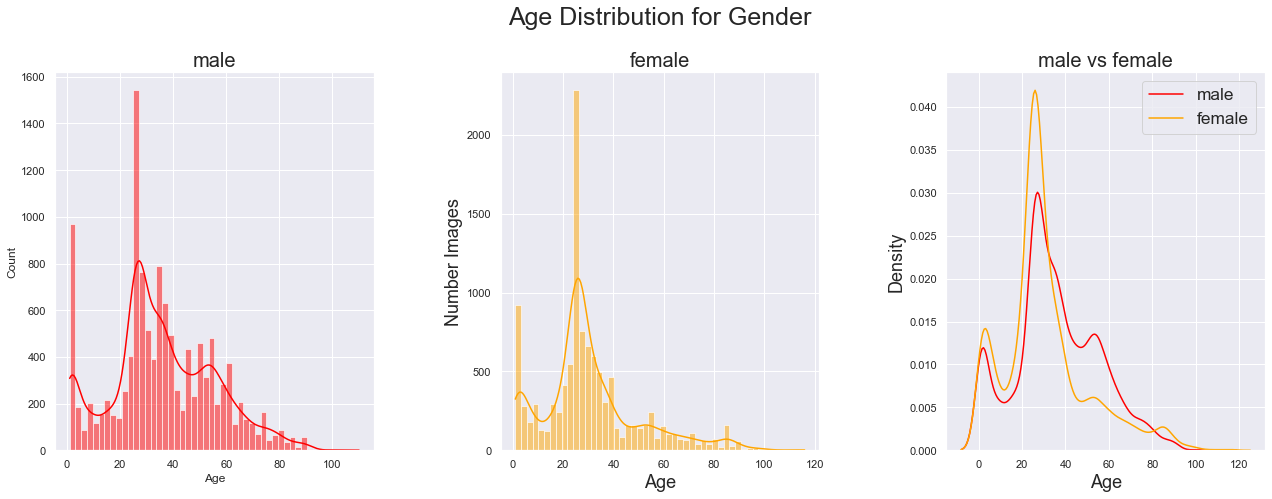

In [13]:
sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Age Distribution for Gender', fontsize=25)
sns.set(font_scale = 1.2)


df_age_male = labels_full.groupby('Gender').get_group(0)
df_age_female = labels_full.groupby('Gender').get_group(1)
h = sns.histplot(data=df_age_male, x = "Age", kde=True, color="red", ax=ax1, bins=50)

h = sns.histplot(data=df_age_female, x="Age", kde=True, color="orange", ax=ax2, bins=50)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
ax1.set_title("male", fontdict = {'fontsize': 20})
ax2.set_title("female", fontdict = {'fontsize': 20})

sns.kdeplot(data=df_age_male, x="Age", color="red", ax=ax3)
h = sns.kdeplot(data=df_age_female, x="Age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.set_title("male vs female", fontdict = {'fontsize': 20})
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Density", fontsize=18)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.4)
plt.show()

2. After Subsetting

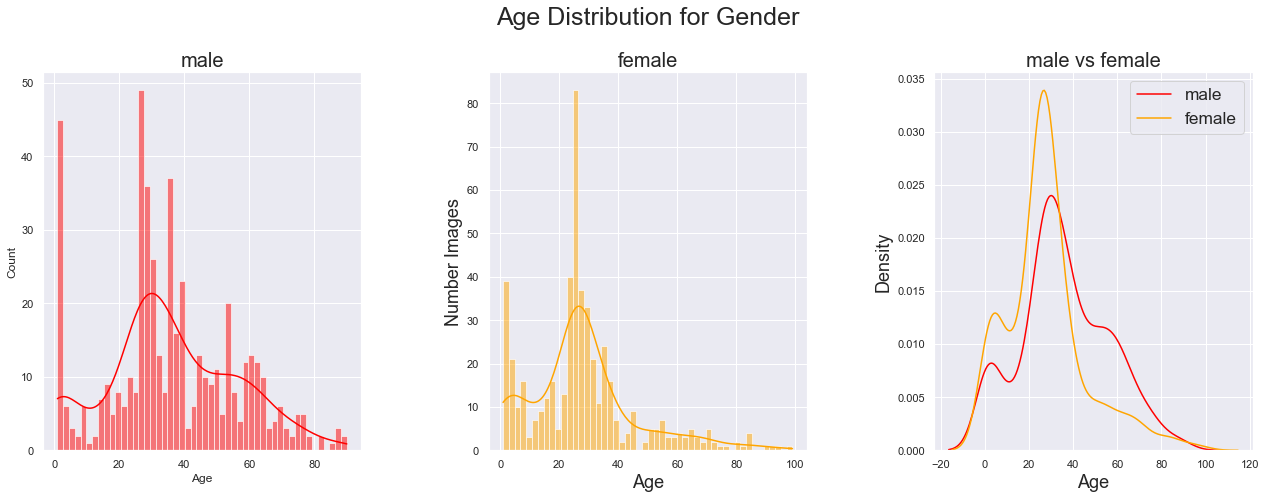

In [14]:

sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Age Distribution for Gender', fontsize=25)
sns.set(font_scale = 1.2)


df_age_male = labels.groupby('Gender').get_group(0)
df_age_female = labels.groupby('Gender').get_group(1)
h = sns.histplot(data=df_age_male, x = "Age", kde=True, color="red", ax=ax1, bins=50)

h = sns.histplot(data=df_age_female, x="Age", kde=True, color="orange", ax=ax2, bins=50)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
ax1.set_title("male", fontdict = {'fontsize': 20})
ax2.set_title("female", fontdict = {'fontsize': 20})


sns.kdeplot(data=df_age_male, x="Age", color="red", ax=ax3)
h = sns.kdeplot(data=df_age_female, x="Age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.set_title("male vs female", fontdict = {'fontsize': 20})
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Density", fontsize=18)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.4)
plt.show()

### Train an SVM on the image domain

In [15]:
indices = np.arange(N)
Xtr, Xts, ytr, yts, ind_tr, ind_ts = train_test_split(X, y, indices, test_size = 0.20, stratify = y, random_state=43)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best estimator: SVC(C=100, gamma=1e-05)


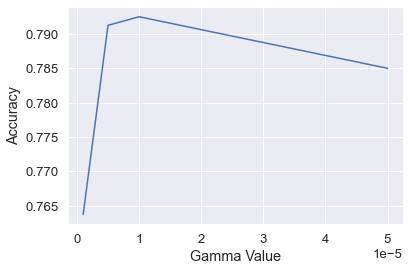

In [16]:
C = 100
svc = SVC(C=C, kernel='rbf')
gamma_values = [1e-6,5e-6,1e-5,5e-5]
param_grid = {
    'gamma': gamma_values    
}


cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 43)
cv_grid = GridSearchCV(estimator = svc, param_grid = param_grid, cv = cv, verbose = 2, n_jobs = -1, scoring = 'accuracy' )

# Fit the grid search model
cv_grid.fit(Xtr, ytr)

#plot the results
plt.plot(gamma_values,cv_grid.cv_results_['mean_test_score'])
plt.xlabel('Gamma Value')
plt.ylabel('Accuracy')
print(f'best estimator: {cv_grid.best_estimator_}')

#### Now check the optimal model's accuracy on the unseen test set

In [17]:
svm_opt = cv_grid.best_estimator_
y_pred = svm_opt.predict(Xts)
accuracy_score(yts, y_pred)

0.785

#### If a Pipeline is needed

Fitting 2 folds for each of 4 candidates, totalling 8 fits
best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(C=100, gamma=0.001))])


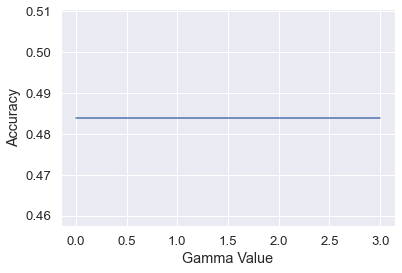

In [18]:
C = 100
svc = SVC(C=C, kernel='rbf')
gamma_values = [1e-3,4e-3,1e-2,1e-1]
param_grid = {
    'model__gamma': gamma_values    
}

# optimal n_splits = 10, n_repeats = 3
pipeline = Pipeline([('scaler', StandardScaler()), ('model', svc)])

cv = RepeatedKFold(n_splits = 2, n_repeats = 1)
cv_grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, verbose = 2, n_jobs = -1, scoring='accuracy' )

pipeline = Pipeline([('scaler', StandardScaler()), ('model', svc)])

# Fit the grid search model
cv_grid.fit(X, y)

#plot the results
plt.plot(range(0, len(gamma_values)),cv_grid.cv_results_['mean_test_score'])
plt.xlabel('Gamma Value')
plt.ylabel('Accuracy')
print(f'best estimator: {cv_grid.best_estimator_}')

In [19]:
cv_grid.cv_results_

{'mean_fit_time': array([13.82471585, 13.84305978, 13.73273671, 13.76227999]),
 'std_fit_time': array([0.01097035, 0.02753377, 0.01309574, 0.02737498]),
 'mean_score_time': array([21.4307276 , 21.19386137, 21.30387092, 21.26617086]),
 'std_score_time': array([0.14262068, 0.01446044, 0.2621057 , 0.13925111]),
 'param_model__gamma': masked_array(data=[0.001, 0.004, 0.01, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__gamma': 0.001},
  {'model__gamma': 0.004},
  {'model__gamma': 0.01},
  {'model__gamma': 0.1}],
 'split0_test_score': array([0.484, 0.484, 0.484, 0.484]),
 'split1_test_score': array([0.484, 0.484, 0.484, 0.484]),
 'mean_test_score': array([0.484, 0.484, 0.484, 0.484]),
 'std_test_score': array([0., 0., 0., 0.]),
 'rank_test_score': array([1, 1, 1, 1])}

### Visualize the Results

#### 1. Confusion Matrix

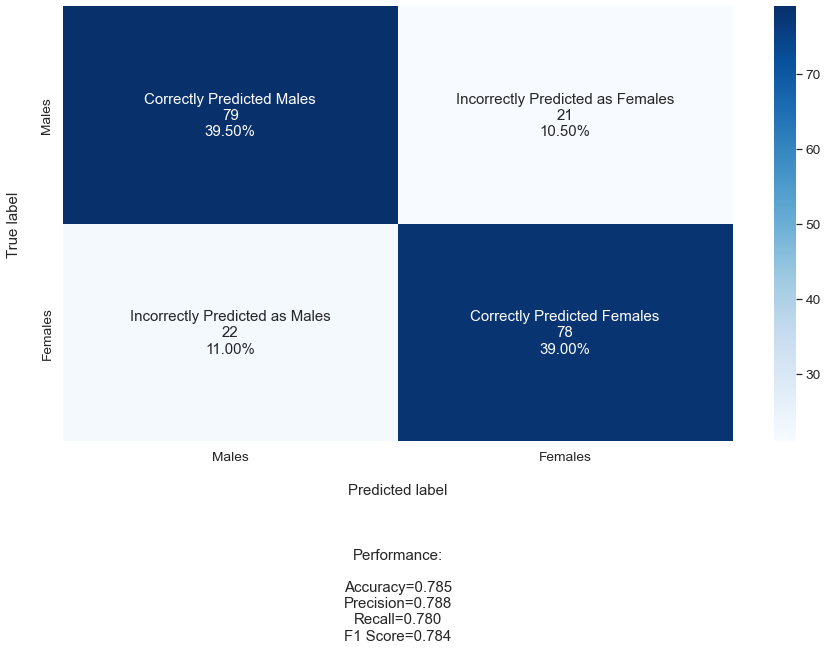

In [20]:
cf_matrix = confusion_matrix(yts, y_pred)

sns.set(font_scale = 1.25)
print()
labels_cf = ['Correctly Predicted Males','Incorrectly Predicted as Females','Incorrectly Predicted as Males','Correctly Predicted Females']
categories = ['Males', 'Females']
make_confusion_matrix(cf_matrix, 
                      group_names=labels_cf,
                      categories=categories,
                      figsize = (15,8),
                      cmap='Blues')

plt.show()

#### Age of incorrectly predicted

In [21]:
incorrect_indices = np.where(np.not_equal(y_pred,yts))
labels_test = labels.iloc[ind_ts,:]
incorrect_labels = labels_test.iloc[incorrect_indices[0],:]

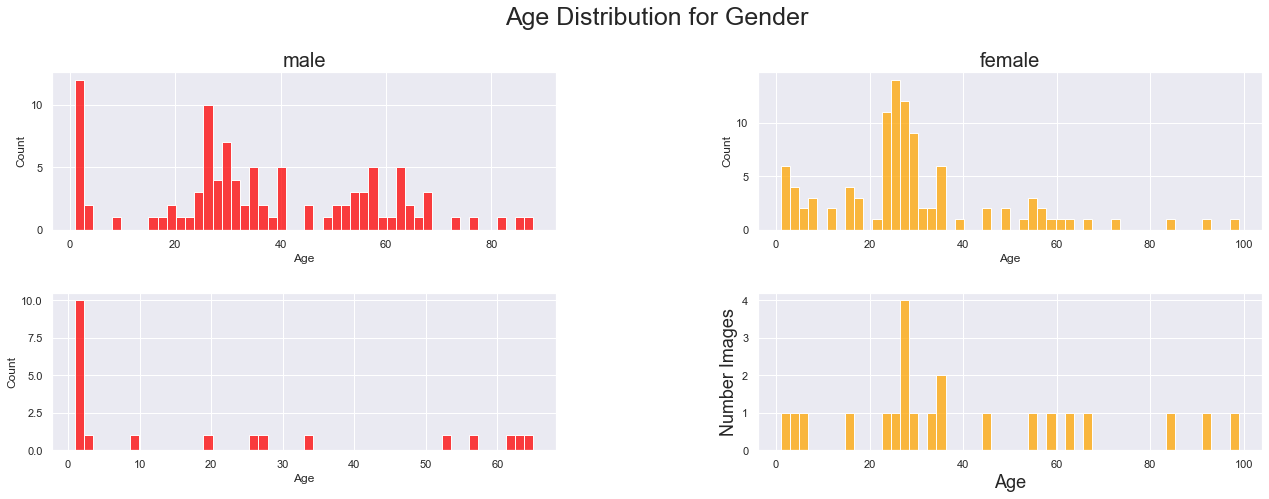

In [22]:
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(21, 7))
fig.suptitle('Age Distribution for Gender', fontsize=25)
sns.set(font_scale = 1.2)
df_age_male_incorrect = incorrect_labels.groupby('Gender').get_group(0)
df_age_female_incorrect = incorrect_labels.groupby('Gender').get_group(1)
df_age_male_test = labels_test.groupby('Gender').get_group(0)
df_age_female_test = labels_test.groupby('Gender').get_group(1)

h = sns.histplot(data=df_age_male_test, x = "Age", color="red", ax = axs[0,0], bins=50)
h = sns.histplot(data=df_age_female_test, x="Age", color="orange", ax=axs[0,1], bins=50)
h = sns.histplot(data=df_age_male_incorrect, x = "Age", color="red", ax = axs[1,0], bins=50)
h = sns.histplot(data=df_age_female_incorrect, x="Age", color="orange", ax=axs[1,1], bins=50)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
axs[0,0].set_title("male", fontdict = {'fontsize': 20})
axs[0,1].set_title("female", fontdict = {'fontsize': 20})


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.4)
plt.show()

## PCA

### 1. Reconstruction from PCA

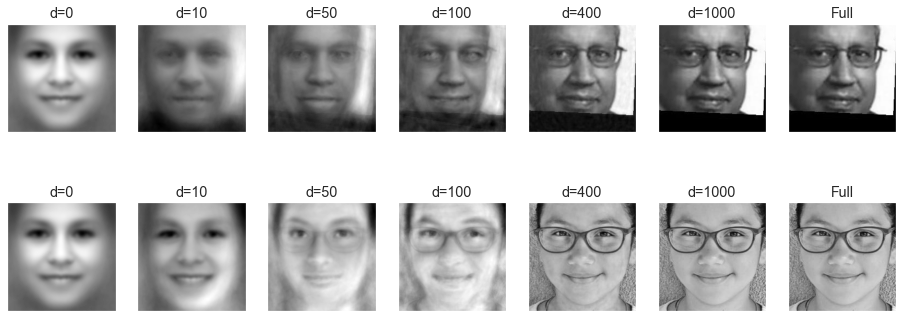

In [23]:
nplt = 2               # number of faces to plot
ds = [0,10,50,100,400, 1000]   # number of SVD approximations
use_pca = True         # True=Use sklearn reconstruction, else use SVD

if use_pca:
    # Construct the PCA object for the max number of coefficient
    dmax = np.max(ds)
    pca = PCA(n_components=dmax, svd_solver='randomized', whiten=True)
    # IncrementalPCA(n_components=dmax, batch_size=10
    # Fit and transform the data
    pca.fit(X)
    Z = pca.transform(X)
    

# Fit the PCA components on the entire dataset
pca.fit(X)

# Select random faces
inds = np.random.permutation(N)
inds = inds[:nplt]
nd = len(ds)

# Set figure size
plt.figure(figsize=(1.8 * (nd+1), 2.4 * nplt))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# Loop over figures
iplt = 0
for ind in inds:
    for d in ds:
        plt.subplot(nplt,nd+1,iplt+1)
        if use_pca:
            # Zero out coefficients after d.  
            # Note, we need to copy to not overwrite the coefficients
            Zd = np.copy(Z[ind,:])
            Zd[d:] = 0
            Xhati = pca.inverse_transform(Zd)
        else:
            # Reconstruct with SVD
            Xhati = (U[ind,:d]*S[None,:d]).dot(Vtr[:d,:]) + Xmean
            
        plt_face(Xhati)
        plt.title('d={0:d}'.format(d))
        iplt += 1
    
    # Plot the true face
    plt.subplot(nplt,nd+1,iplt+1)
    plt_face(X[ind,:])
    plt.title('Full')
    iplt += 1

#### 2. GridSearch for PCA

In [24]:
X_tr_in, X_val, y_tr_in, y_val = train_test_split(Xtr, ytr, test_size=0.20, stratify = ytr, random_state=43)

In [25]:
#Select Parameters
npc_test = [1,2,5,10,25,50,75,100,200]#,400,600]
gam_test = [5e-4,1e-3,4e-3,1e-2,1e-1]
C = 100
n0 = len(npc_test)
n1 = len(gam_test)
acc = np.zeros((n0,n1))
acc_max = 0

for i0, npc in enumerate(npc_test):
    
    # Fit PCA on the training data
    pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
    pca.fit(X_tr_in)

    # Transform the training and test
    Ztr = pca.transform(X_tr_in)
    Zvl = pca.transform(X_val)
    
    for i1, gam in enumerate(gam_test):
                
        # Fiting on the transformed training data
        svc = SVC(C=C, kernel='rbf', gamma = gam)
        svc.fit(Ztr, y_tr_in)
        
        # Predict on the test data
        yhat = svc.predict(Zvl)
        
        # Compute the accuracy
        acc[i0,i1] = accuracy_score(y_val, yhat)
        print('npc=%d gam=%12.4e acc=%12.4e' % (npc,gam,acc[i0,i1]))
        
        # Save the optimal parameters
        if acc[i0,i1] > acc_max:
            gam_opt = gam
            npc_opt = npc
            acc_max = acc[i0,i1]

npc=1 gam=  5.0000e-04 acc=  4.8750e-01
npc=1 gam=  1.0000e-03 acc=  4.8750e-01
npc=1 gam=  4.0000e-03 acc=  4.7500e-01
npc=1 gam=  1.0000e-02 acc=  4.6250e-01
npc=1 gam=  1.0000e-01 acc=  4.8125e-01
npc=2 gam=  5.0000e-04 acc=  5.0625e-01
npc=2 gam=  1.0000e-03 acc=  4.9375e-01
npc=2 gam=  4.0000e-03 acc=  5.0625e-01
npc=2 gam=  1.0000e-02 acc=  5.2500e-01
npc=2 gam=  1.0000e-01 acc=  5.1875e-01
npc=5 gam=  5.0000e-04 acc=  6.2500e-01
npc=5 gam=  1.0000e-03 acc=  6.3750e-01
npc=5 gam=  4.0000e-03 acc=  6.5625e-01
npc=5 gam=  1.0000e-02 acc=  6.5000e-01
npc=5 gam=  1.0000e-01 acc=  5.9375e-01
npc=10 gam=  5.0000e-04 acc=  6.8750e-01
npc=10 gam=  1.0000e-03 acc=  6.8125e-01
npc=10 gam=  4.0000e-03 acc=  6.6250e-01
npc=10 gam=  1.0000e-02 acc=  6.5000e-01
npc=10 gam=  1.0000e-01 acc=  6.8125e-01
npc=25 gam=  5.0000e-04 acc=  7.3125e-01
npc=25 gam=  1.0000e-03 acc=  7.3750e-01
npc=25 gam=  4.0000e-03 acc=  7.5625e-01
npc=25 gam=  1.0000e-02 acc=  7.2500e-01
npc=25 gam=  1.0000e-01 acc=  7

#### Check accuracy on the unseen Test set

In [26]:
pca = PCA(n_components=npc_opt, svd_solver='randomized', whiten=True)
pca.fit(Xtr)

# Transform the training and test
Ztr = pca.transform(Xtr)
Zts = pca.transform(Xts)

# Fitting on the transformed training data
svc = SVC(C=C, kernel='rbf', gamma = gam_opt)
svc.fit(Ztr, ytr)

# Predict on the test data
yhat = svc.predict(Zts)

# Compute the accuracy
acc = accuracy_score(yts, yhat)
print('nc=%d gam=%12.4e acc=%.3f' % (npc_opt,gam_opt,acc))

nc=50 gam=  5.0000e-04 acc=0.780


### 3. Explained Variance

Number of components explaining 90% variance: 56


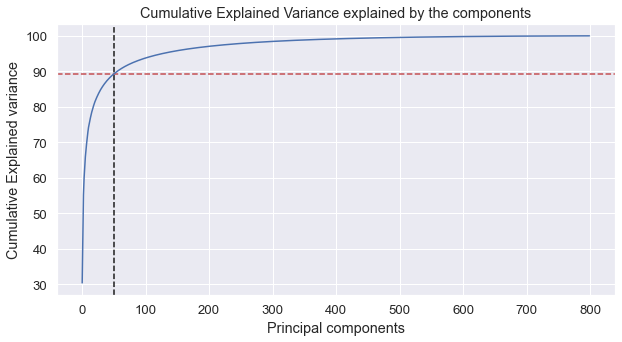

In [27]:
pca = PCA()
pca.fit(Xtr)
 
# Getting the cumulative variance
 
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
 
# How many PCs explain 95% of the variance?
k1 = np.argmax(var_cumu>90)
print("Number of components explaining 90% variance: "+ str(k1))
#print("\n")
 
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=npc_opt, color="k", linestyle="--")
plt.axhline(y = var_cumu[npc_opt], color="r", linestyle="--")
ax = plt.plot(var_cumu)

### 4. Plot Eigenfaces

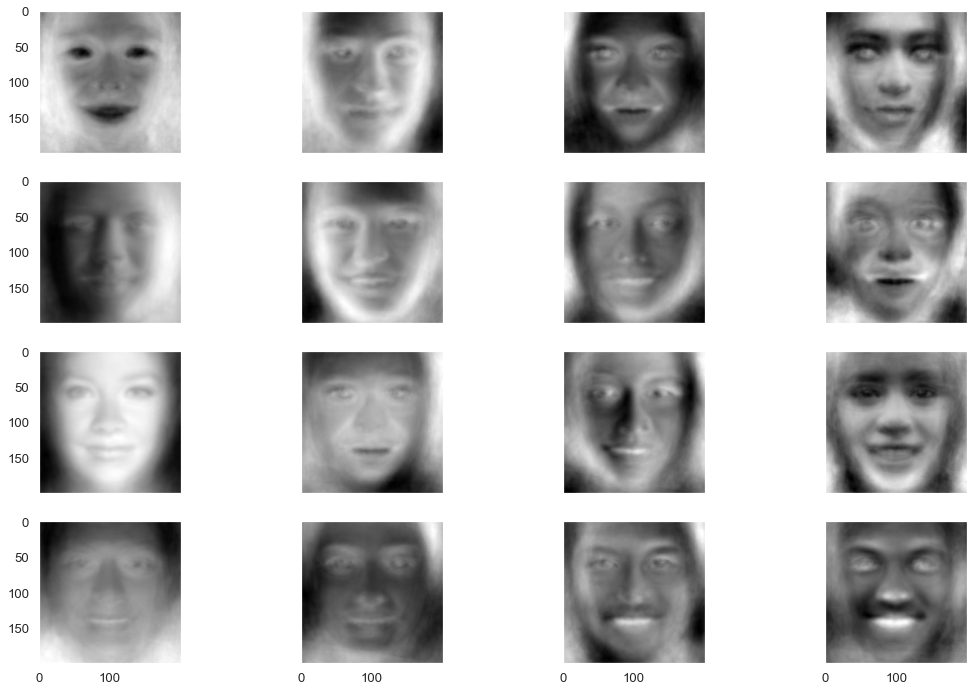

In [28]:
# Take the first K principal components as eigenfaces
n_components = 50
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

pca = PCA(n_components=npc_opt, svd_solver='randomized', whiten=True)
pca.fit(Xtr)
eigenfaces = pca.components_
 
# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(18,12))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape([200,200]), cmap="gray")
plt.show()

### 5. Projection of data into the 3 Principal directions

In [29]:
import plotly.express as px
pca = PCA()
pca.fit(Xtr)
principalComponents = pca.transform(Xtr)
# Save components to a DataFrame
PCA_df = pd.DataFrame(principalComponents)
PCA_df = PCA_df.rename(columns = {0:"PC1", 1:"PC2", 2:"PC3"})
PCA_df['label'] = ytr
fig = px.scatter_3d(PCA_df, x='PC1', y='PC2', z = 'PC3', color='label', title="Data Projected into 3 Principal Directions")
fig.update_traces(marker_size = 3)
fig.show()

### 6. KMeans Clustering

##### Check the optimal number of clusters using the optimal number of principal components acoording to SVM

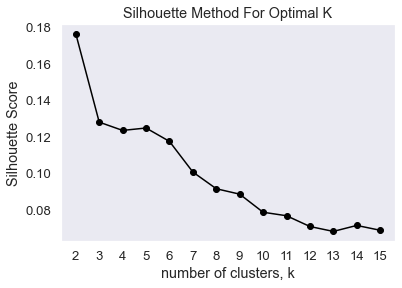

Optimal Number of  Clusters=2


In [30]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(principalComponents[:,:200])
    labels_cl = kmeans.labels_
    sil.append(silhouette_score(principalComponents[:,:200], labels_cl, metric = 'euclidean'))
    
opt_no_clusters = np.argmax(sil)+2
    
plt.plot(np.arange(2,kmax+1), sil, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(2,kmax+1))
plt.title('Silhouette Method For Optimal K')
plt.show()
print('Optimal Number of  Clusters=%d' % (opt_no_clusters))

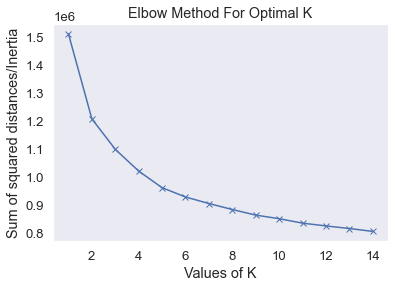

In [31]:
Sum_of_squared_distances = []
K = range(1,15)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(principalComponents[:,:200])
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
#plt.arrow(6, 1.5, 1, 1, width = 0.05)
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal K')
plt.show()

##### Train Kmeans

In [32]:
kmeans = KMeans(n_clusters=opt_no_clusters)
kmeans.fit(principalComponents[:,:200])
lab = kmeans.labels_

In [33]:
indexes_of_2_clusters = [np.where(lab==0)[0],np.where(lab==1)[0]]

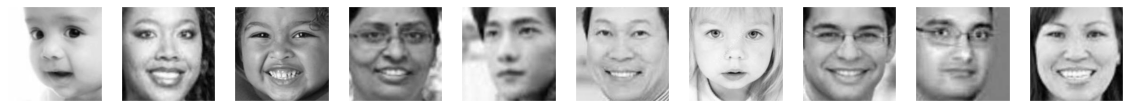

In [34]:
n_samples = len(indexes_of_2_clusters[0])
I = np.random.permutation(n_samples)
plt.figure(figsize=(20,40))
nplt = 10;
for i in range(nplt):    
    ind = indexes_of_2_clusters[0][I[i]]
    plt.subplot(1,nplt,i+1)
    plt_face(Xtr[ind,:])

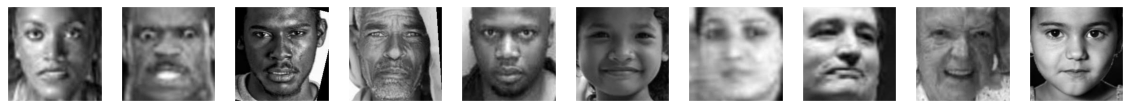

In [35]:
n_samples = len(indexes_of_2_clusters[1])
I = np.random.permutation(n_samples)
plt.figure(figsize=(20,40))
nplt = 10;
for i in range(nplt):    
    ind = indexes_of_2_clusters[1][I[i]]
    plt.subplot(1,nplt,i+1)
    plt_face(Xtr[ind,:])

##### We observe that clustering divided the images into 2 clusters according to the brightness of each image

Lets discover know if the labels are connected to the clusters

In [36]:
cluster0_lab = labels.iloc[ind_tr[indexes_of_2_clusters[0]],:]
cluster1_lab = labels.iloc[ind_tr[indexes_of_2_clusters[1]],:]

In [37]:
cluster0_lab

Age  Gender  Race
14456   37       1     4
14756   38       1     3
14587   38       0     2
6643    26       0     4
17693    4       1     0
...    ...     ...   ...
15181    3       1     0
9975    29       1     2
8380    27       1     2
8336    27       1     1
17924   50       0     0

[335 rows x 3 columns]

Text(0.5, 0.98, 'Age distibution of the 2 clusters')

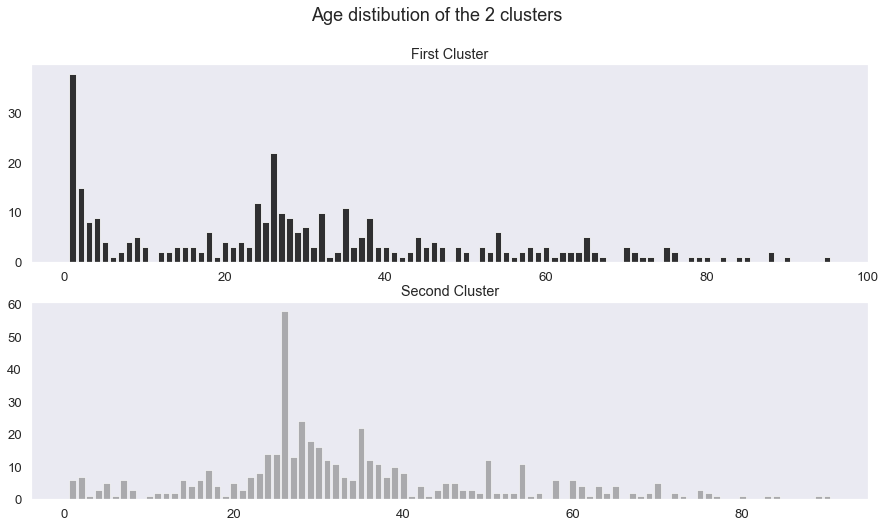

In [38]:
age_0 = cluster0_lab.groupby(['Age'])['Age'].size()
age_1 = cluster1_lab.groupby(['Age'])['Age'].size()
fig = plt.figure(figsize=(15, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.bar(age_0.index, age_0.values, align='center', alpha=0.8, color='black')
ax1.title.set_text('First Cluster')
ax2 = plt.subplot(2, 1, 2)
ax2.bar(age_1.index, age_1.values, align='center', alpha=0.6, color='gray')
ax2.title.set_text('Second Cluster')
fig.suptitle('Age distibution of the 2 clusters',  fontsize=18)

C:\Users\panag\AppData\Local\Temp\ipykernel_11552\1922026102.py:19: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



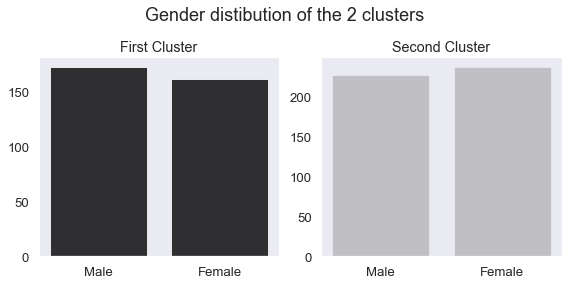

In [39]:
gender_titles = ['Male', 'Female']
gender_0 = cluster0_lab.groupby(['Gender'])['Gender'].size()
gender_1 = cluster1_lab.groupby(['Gender'])['Gender'].size()
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].bar(gender_0.index, gender_0.values, align='center', alpha=0.8, color='black')
plt.sca(axes[0])
plt.xticks([0, 1], gender_titles)

axes[0].title.set_text('First Cluster')

axes[1].bar(gender_1.index, gender_1.values, align='center', alpha=0.4, color='grey')
plt.sca(axes[1])
plt.xticks([0, 1], gender_titles)

axes[1].title.set_text('Second Cluster')

fig.suptitle('Gender distibution of the 2 clusters',  fontsize=18)
fig.set_tight_layout(True)
fig.show()

C:\Users\panag\AppData\Local\Temp\ipykernel_11552\485668325.py:19: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



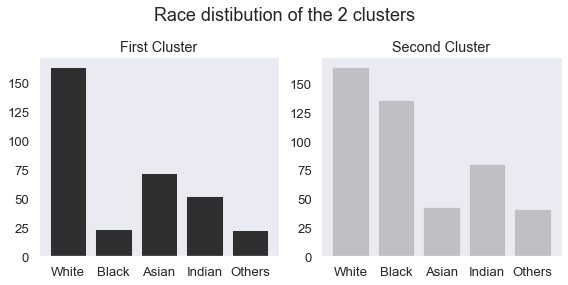

In [40]:
races_titles = ['White', 'Black', 'Asian', 'Indian','Others']
race_0 = cluster0_lab.groupby(['Race'])['Race'].size()
race_1 = cluster1_lab.groupby(['Race'])['Race'].size()
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].bar(race_0.index, race_0.values, align='center', alpha=0.8, color='black')
plt.sca(axes[0])
plt.xticks([0, 1, 2,3,4], races_titles)

axes[0].title.set_text('First Cluster')

axes[1].bar(race_1.index, race_1.values, align='center', alpha=0.4, color='grey')
plt.sca(axes[1])
plt.xticks([0, 1, 2,3,4], races_titles)

axes[1].title.set_text('Second Cluster')

fig.suptitle('Race distibution of the 2 clusters',  fontsize=18)
fig.set_tight_layout(True)
fig.show()

In [41]:
PCA_df['cluster'] = lab
PCA_df['cluster'] = PCA_df['cluster'].astype(str)
fig = px.scatter_3d(PCA_df, x='PC1', y='PC2', z = 'PC3', color='cluster', title="Clusters Projected into 3 Principal Directions")
fig.update_traces(marker_size = 3)
#fig.update_layout(legend=dict(title_font_family="Times New Roman",
#                              font=dict(size= 20)))

fig.update_layout(legend=dict(y=1, x=0.1))
fig.show()